<a href="https://colab.research.google.com/github/my000own000files1/Fuzzy/blob/main/lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

\[\begin{cases} \frac{dx}{dt}=\dot{x} \\ \frac{d\dot{x}}{dt}=-6\dot{x}-x-u(t)   \end{cases} \]
$$y(t)=x(t)$$

In [16]:
!pip install -U scikit-fuzzy

Requirement already up-to-date: scikit-fuzzy in /usr/local/lib/python3.7/dist-packages (0.4.2)


In [17]:
  !pip install -U control

Requirement already up-to-date: control in /usr/local/lib/python3.7/dist-packages (0.9.0)


In [18]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import control as ct
from control.matlab import * #I want to have a MATLAB-like environment
import matplotlib.pyplot as plt
import scipy as sp

In [60]:
#creating object dynamics
def port_crane_updfcn(t,s,u,params):

  # Define variables for object state
  x = s[0]    
  dx = s[1]

  # calculating the output variables 
  ddx = -6*dx-x+u[0]

  return np.array([dx,ddx])

def port_crane_outfcn(t, s, u, params):
  return s[0]

In [30]:
# Define a generator for creating a plots
def system_dynamic_plot(sys, t, y, u, t_start_input=0, y_ref=0, linetype='b-',
                         subplots=[None],fig_size=None):
  #Figure out the plot bounds and indices
  y_min = 0; y_max = y_ref+math.ceil(y_ref*0.05); y_ind = sys.find_output('y')
#  phi_min = -math.pi/18; phi_may = math.pi/18; phi_ind = sys.find_state('ddx')
  u_min = 0; u_max = max(u); u_ind = sys.find_input('u') 
  graph_max=max([y_max,u_max])
  graph_min=min([y_min,u_min])
  # Make sure the upper and lower bounds for y are OK
  if len(y.shape)>1:
    while max(y[y_ind]) > graph_max: graph_max += 1
    while min(y[y_ind]) < graph_min: graph_min -= 1
  else:
    while max(y) > graph_max: graph_max += 1
    while min(y) < graph_min: graph_min -= 1
    
  # Make sure the upper and lower bounds for Fe are OK
  if len(u.shape)>1:
    while max(u[u_ind]) > graph_max: graph_max += 1
    while min(u[u_ind]) < graph_min: graph_min -= 1
  else:
    while max(u) >graph_max: graph_max += 1
    while min(u) <graph_min: graph_min -= 1
  graph_min-=1
  graph_max+=1
  # Create arrays for return values
  subplot_axes = subplots.copy()

 # System profiles
  if subplot_axes[0] is None:
    subplot_axes[0] = plt.subplot(1,1,1)
  else:
    plt.sca(subplots[0])
  if len(y.shape)>1:
    plt.plot(t, y[y_ind], '-',c='indigo')
  else:
    plt.plot(t, y, '-',c='indigo')
  plt.plot(t, y_ref*np.ones(t.shape), 'k--')
  plt.plot([t_start_input, t_start_input], [y_min, y_max], 'b--')
  if len(u.shape)>1:
    plt.plot(t, u[u_ind], '-',color='darkblue')
  else:
    plt.plot(t, u, '-',color='darkblue')    
  plt.axis([0, t[-1], graph_min, graph_max])
  #print(graph_min)
  plt.xlabel('Time $t$ [s]')
  plt.ylabel('$y,u$')
  plt.grid(color='0.5')
    
  return subplot_axes

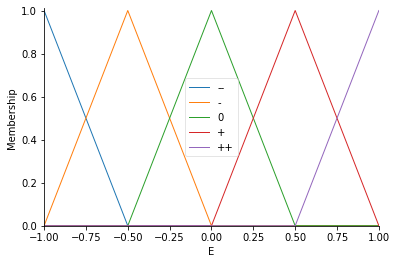

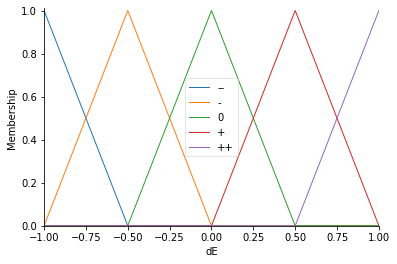

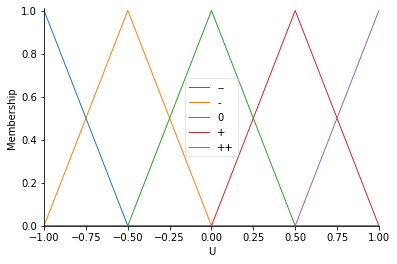

In [21]:
#Параметры моделирования системы

#Сгенерировали нечёткую систему

#Fuzzy regulator parameters init
E_abs=1
E_min=-E_abs
E_max=E_abs
dE_abs=1
dE_min=-dE_abs
dE_max=dE_abs
dU_abs=1
dU_min=-dU_abs
dU_max=dU_abs

# New Antecedent/Consequent objects hold universe variables and
# continues membership functions
N=1e3 # count of point for the universe
E = ctrl.Antecedent(np.linspace(E_min, E_max, int(N+1)), 'E') # input in m with 
dE = ctrl.Antecedent(np.linspace(dE_min, dE_max, int(N+1)), 'dE') # in rad
U = ctrl.Consequent(np.linspace(dU_min, dU_max, int(N+1)), 'U')

# Custom membership functions can be built interactively with a familiar,
# Pythonic API
# Auto-membership function population 
names=['--','-','0','+','++']
E.automf(5,names=names)
dE.automf(5,names=names)
U.automf(5,names=names)

E.view()
dE.view()
U.view()

#создание базы правил нечеткой системы
#Fuzzy rules
rule0 = ctrl.Rule(antecedent=((E['--'] & dE['--']) |
                              (E['-'] & dE['--']) |
                              (E['--'] & dE['-']) ),
                  consequent=U['--'], label='rule --')

rule1 = ctrl.Rule(antecedent=((E['0'] & dE['--']) |
                              (E['+'] & dE['--']) |
                              (E['-'] & dE['-']) |
                              (E['0'] & dE['-']) |                              
                              (E['--'] & dE['0']) |                              
                              (E['-'] & dE['0']) |                              
                              (E['--'] & dE['+'])),
                  consequent=U['-'], label='rule -')

rule2 = ctrl.Rule(antecedent=((E['--'] & dE['++']) |
                              (E['-'] & dE['+']) |
                              (E['0'] & dE['0']) |
                              (E['+'] & dE['-']) |                              
                              (E['++'] & dE['--'])),
                  consequent=U['0'], label='rule 0')

rule3 = ctrl.Rule(antecedent=((E['++'] & dE['-']) |
                              (E['+'] & dE['0']) |
                              (E['++'] & dE['0']) |
                              (E['0'] & dE['+']) |                              
                              (E['+'] & dE['+']) |                              
                              (E['-'] & dE['++']) |                              
                              (E['0'] & dE['++'])),
                  consequent=U['+'], label='rule +')

rule4 = ctrl.Rule(antecedent=((E['++'] & dE['+']) |
                              (E['+'] & dE['++']) |
                              (E['++'] & dE['++']) ),
                  consequent=U['++'], label='rule ++')

#Control System Creation 
sys_ctrl = ctrl.ControlSystem([rule0, rule1, rule2, rule3, rule4 ])
sys_sim = ctrl.ControlSystemSimulation(sys_ctrl)


In [57]:
# # Pass inputs to the ControlSystem using Antecedent labels with Pythonic API
# # Note: if you like passing many inputs all at once, use .inputs(dict_of_data)
# sys_sim.input['E'] = 0.5
# sys_sim.input['dE'] = 0

# # Crunch the numbers
# sys_sim.compute()

# print(sys_sim.output['U'])

0.49999999999999983


In [64]:
#nonlinearsystem

def _rhs(self, t, x, u):
    xdot = self.updfcn(t, x, u, self._current_params) \
        if self.updfcn is not None else []
    return np.array(xdot).reshape((-1,))

def _out(self, t, x, u):
    y = self.outfcn(t, x, u, self._current_params) \
        if self.outfcn is not None else x
    return np.array(y).reshape((-1,))

#input_output_response

def _check_convert_array(in_obj, legal_shapes, err_msg_start, squeeze=False,
                         transpose=False):
  # convert nearly everything to an array.
    out_array = np.asarray(in_obj)
    if (transpose):
        out_array = np.transpose(out_array)

    # Test element data type, elements must be numbers
    legal_kinds = set(("i", "f", "c"))  # integer, float, complex
    if out_array.dtype.kind not in legal_kinds:
        err_msg = "Wrong element data type: '{d}'. Array elements " \
                  "must be numbers.".format(d=str(out_array.dtype))
        raise TypeError(err_msg_start + err_msg)

    # If array is zero dimensional (in_obj is scalar):
    # create array with legal shape filled with the original value.
    if out_array.ndim == 0:
        for s_legal in legal_shapes:
            # search for shape that does not contain the special symbol any.
            if "any" in s_legal:
                continue
            the_val = out_array[()]
            out_array = np.empty(s_legal, 'd')
            out_array.fill(the_val)
            break

    # Test shape
    def shape_matches(s_legal, s_actual):
        """Test if two shape tuples match"""
        # Array must have required number of dimensions
        if len(s_legal) != len(s_actual):
            return False
        # All dimensions must contain required number of elements. Joker: "all"
        for n_legal, n_actual in zip(s_legal, s_actual):
            if n_legal == "any":
                continue
            if n_legal != n_actual:
                return False
        return True

    # Iterate over legal shapes, and see if any matches out_array's shape.
    for s_legal in legal_shapes:
        if shape_matches(s_legal, out_array.shape):
            break
    else:
        legal_shape_str = " or ".join([str(s) for s in legal_shapes])
        err_msg = "Wrong shape (rows, columns): {a}. Expected: {e}." \
                  .format(e=legal_shape_str, a=str(out_array.shape))
        raise ValueError(err_msg_start + err_msg)

    # Convert shape
    if squeeze:
        out_array = np.squeeze(out_array)
        # We don't want zero dimensional arrays
        if out_array.shape == tuple():
            out_array = out_array.reshape((1,))

    return out_array

def _update_params(self, params, warning=False):
  # Update the current parameter values
  self._current_params = self.params.copy()
  self._current_params.update(params)

def _find_size(sysval, vecval):
    """Utility function to find the size of a system parameter
    If both parameters are not None, they must be consistent.
    """
    if hasattr(vecval, '__len__'):
        if sysval is not None and sysval != len(vecval):
            raise ValueError("Inconsistend information to determine size "
                             "of system component")
        return len(vecval)
    # None or 0, which is a valid value for "a (sysval, ) vector of zeros".
    if not vecval:
        return 0 if sysval is None else sysval
    elif sysval == 1:
        # (1, scalar) is also a valid combination from legacy code
        return 1
    raise ValueError("Can't determine size of system component.")

def _process_time_response(
        sys, tout, yout, xout, u,transpose=None, return_x=False,return_t_u_y = False,
        squeeze=None, input=None, output=None):
      # If squeeze was not specified, figure out the default (might remain None)
    if squeeze is None:
        squeeze = config.defaults['control.squeeze_time_response']

    # Determine if the system is SISO
    issiso = sys.issiso() or (input is not None and output is not None)

    # Figure out whether and how to squeeze output data
    if squeeze is True:         # squeeze all dimensions
        yout = np.squeeze(yout)
    elif squeeze is False:      # squeeze no dimensions
        pass
    elif squeeze is None:       # squeeze signals if SISO
        if issiso:
            if len(yout.shape) == 3:
                yout = yout[0][0]       # remove input and output
            else:
                yout = yout[0]          # remove input
    else:
        raise ValueError("unknown squeeze value")

    # Figure out whether and how to squeeze the state data
    if issiso and xout is not None and len(xout.shape) > 2:
        xout = xout[:, 0, :]            # remove input

    # See if we need to transpose the data back into MATLAB form
    if transpose:
        # Transpose time vector in case we are using np.matrix
        tout = np.transpose(tout)

        # For signals, put the last index (time) into the first slot
        yout = np.transpose(yout, np.roll(range(yout.ndim), 1))
        if xout is not None:
            xout = np.transpose(xout, np.roll(range(xout.ndim), 1))

    # Return time, output, and (optionally) state
    if return_x: 
      return (yout, xout) 
    elif return_t_u_y:  
      return (tout, u, yout)
    else:
      return (yout)

def input_output_response(
        sys, T, y_zad=0., X0=0, params={},
        transpose=False, return_t_u_y=False, squeeze=None,Fuzzy_regulator=None,
        solve_ivp_kwargs={}, **kwargs):
  """Compute the output response of a system to a given input.'''
  """

  # Set the default method to 'RK45'
  if solve_ivp_kwargs.get('method', None) is None:
    solve_ivp_kwargs['method'] = 'RK45'

  # Compute the time interval and number of steps
  T0, Tf = T[0], T[-1]
  n_steps = len(T)  
  dt=T[1]-T[0]
  # Update the parameter values
  sys._update_params(params)
  
  global U,Tnew
  U=[]
  Tnew=[]
  # E=[]
  # dE=[]
  def ufun(t,x):
    global U,Tnew
    Tnew=np.append(Tnew,t)
    sys_sim.input['E'] = -x[0]+y_zad 
    sys_sim.input['dE'] = x[1] 
    sys_sim.compute()
    U=np.append(U,sys_sim.output['U'])
    # E=np.append(E,-x[0]+y_zad)
    # dE=np.append(dE,x[1])
    return [U[-1]]

  # Create a lambda function for the right hand side
  def ivp_rhs(t, x):
    return sys._rhs(t, x, ufun(t,x))

  if not hasattr(sp.integrate, 'solve_ivp'):
    raise NameError("scipy.integrate.solve_ivp not found; "
                        "use SciPy 1.0 or greater")
  soln = sp.integrate.solve_ivp(
      ivp_rhs, (T0, Tf), X0, t_eval=T,
      vectorized=False, **solve_ivp_kwargs) #шаг расчёта переменный

  U=np.interp(T,Tnew,U)


  if sys.ninputs is None or sys.ninputs == 1:
      legal_shapes = [(n_steps,), (1, n_steps)]
  else:
      legal_shapes = [(sys.ninputs, n_steps)]

  #U = _check_convert_array(U, legal_shapes,
  #                        'Parameter ``U``: ', squeeze=False)

  # Compute the output associated with the state (and use sys.out to
  # figure out the number of outputs just in case it wasn't specified)
  y = np.zeros((np.shape(sys._out(T[0], X0, y_zad))[0], len(T)))
  u = U[0] if len(U.shape) == 1 else U[:, 0]
  for i in range(len(T)):
    u = U[i] if len(U.shape) == 1 else U[:, i]
    y[:, i] = sys._out(T[i], soln.y[:, i], u )
                       
  return _process_time_response(sys, T, y, soln.y,U, transpose=transpose,
                                  return_t_u_y=return_t_u_y, squeeze=squeeze)

In [61]:
#Input/ouput model for the object (!but it is a linear system!)
sys_object = ct.NonlinearIOSystem(port_crane_updfcn, port_crane_outfcn, 
                   inputs = ('u'), outputs = ('y'), states=('x','dx'),
                   name='sys_object',params={})

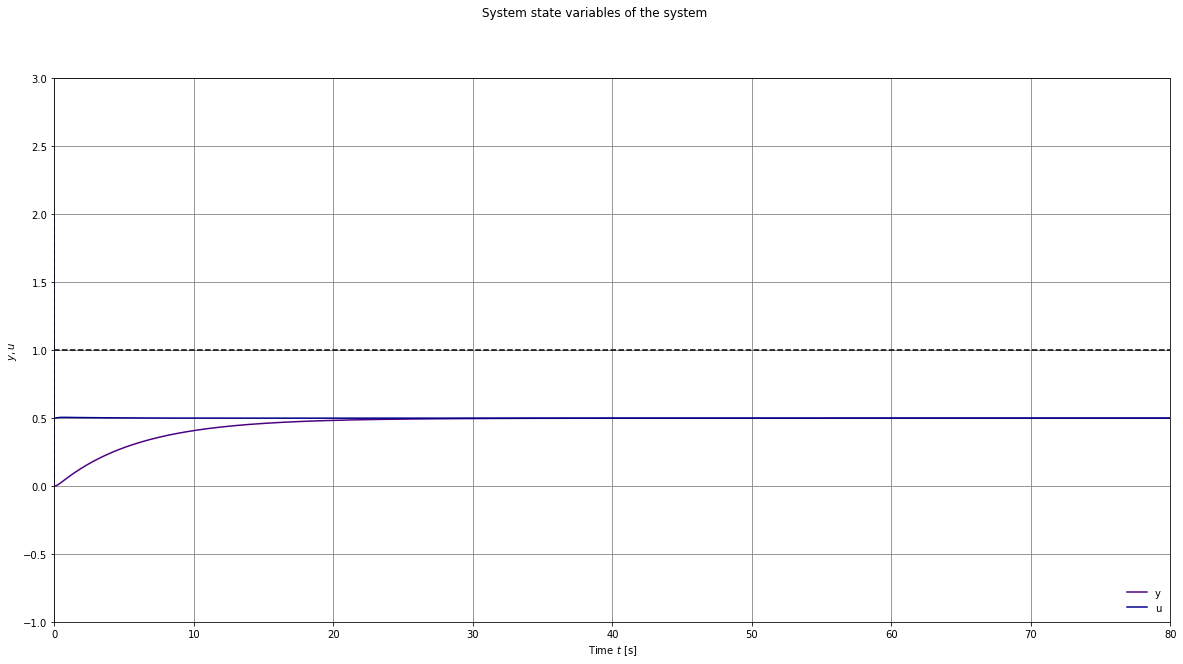

In [62]:
# Define the generator for simulating an aoutonomus object whithout
# controller, when state var equal to null. And also Fe = constant
import math
y_zad=1 
# Define the time and input vectors
# Force starts from (time_start_force) sec and continue during  (time_application_of_force) sec of
# interval and than force become zero before the end of tine interval 
time_start_force=0
time_interval_stop = 80 # length of time interval in sec 
time_application_of_force = time_interval_stop - time_start_force
T_N=int(1e3+1) #points for simulation
T = np.linspace(0, time_interval_stop, (T_N))
N_time_start_force = math.ceil((time_start_force/time_interval_stop)*(T_N))
N_time_application_of_force = math.ceil((time_application_of_force/time_interval_stop)*(T_N))

# linear force increase
# u=np.array([0])
# system single step response 
# u = np.concatenate(( np.zeros(N_time_start_force),
#             np.ones(N_time_application_of_force) ))

init_state_vars = [0,0] #[dx,ddx]
# Response of the system
sys_initial_state = np.array([[0],[0]]) 
(tout, u, sys_state) = input_output_response(sys_object, T, y_zad,sys_initial_state[0:2,0],
                                  params={},Fuzzy_regulator=sys_sim,return_t_u_y=True)   

#create graphics
figsize=(20,10)
plt.figure(figsize=figsize)  
subplots = system_dynamic_plot(sys_object, tout, sys_state, u=u ,y_ref=y_zad,
         t_start_input=time_start_force, linetype='-b',fig_size=figsize)

# Add title and legend
plt.suptitle('System state variables of the system')
import matplotlib.lines as mlines
y_line = mlines.Line2D([], [], color='indigo', linestyle='-', label='y')
u_line = mlines.Line2D([], [], color='darkblue', linestyle='-', label='u') 
plt.legend(handles=[y_line, u_line], frameon=False, loc='lower right') 

In [32]:
print(sys_state)
print(u)

[0.         0.00137009 0.00473798 ... 0.49999131 0.49999137 0.49999153]
[-0.5        -0.49811889 -0.49290177 ... -0.50000001 -0.50000001
 -0.49999741]


In [ ]:
graph_max

In [ ]:

from math import sin,cos,sqrt,atan
ddx  = ddx.evalf(subs={ 'x':3,'dx':2,'phi':2,'dphi':2,'m':230,'M':6000,'k1':0,'k2':0,'g':9.8,'L':30,'Fe':800  })
print(ddphi.evalf(subs={ 'x':3,'dx':2,'phi':2,'dphi':2,'m':230,'M':6000,'k1':0,'k2':0,'g':9.8,'L':30,'Fe':800 ,'ddx':ddx }))

In [ ]:
type(y_sfb )

In [ ]:
def port_crane_outdcn(t ,x ,u , param={})
  # Get the port crane parameters that we need
  